<a href="https://colab.research.google.com/github/prakash-bisht/NN_Architecture_From_Scratch/blob/main/llama2_to_llama3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

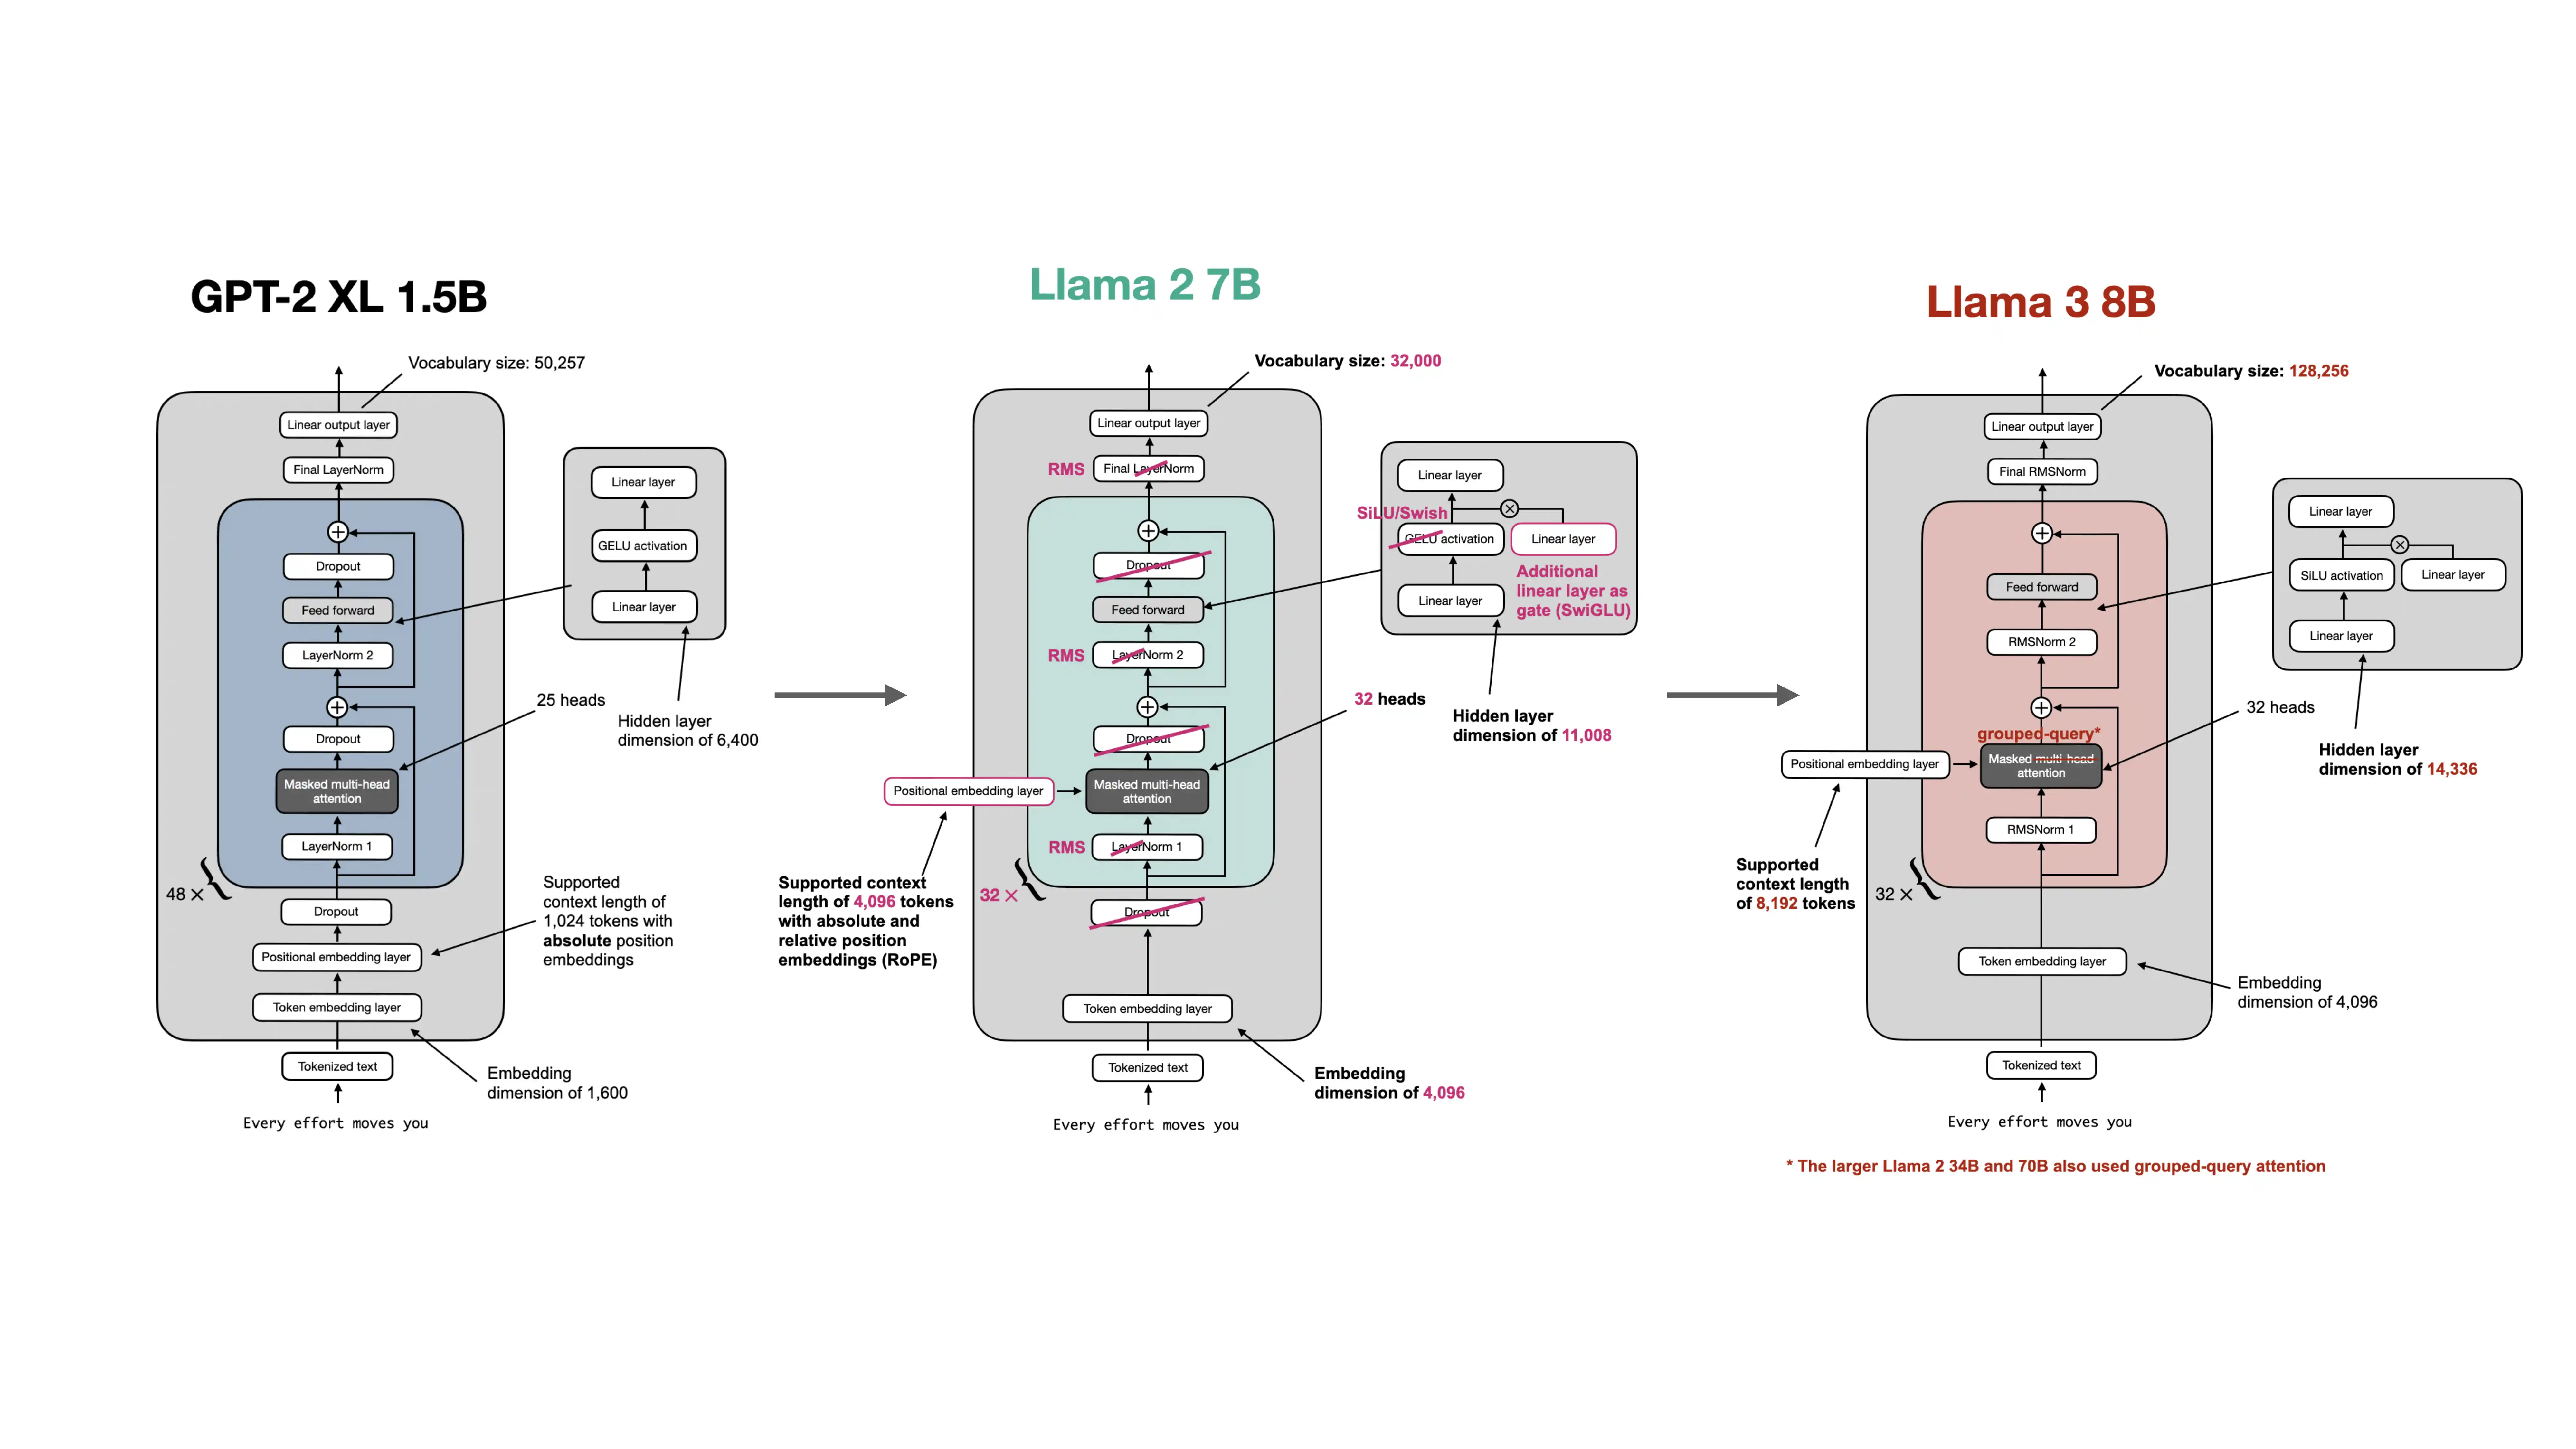

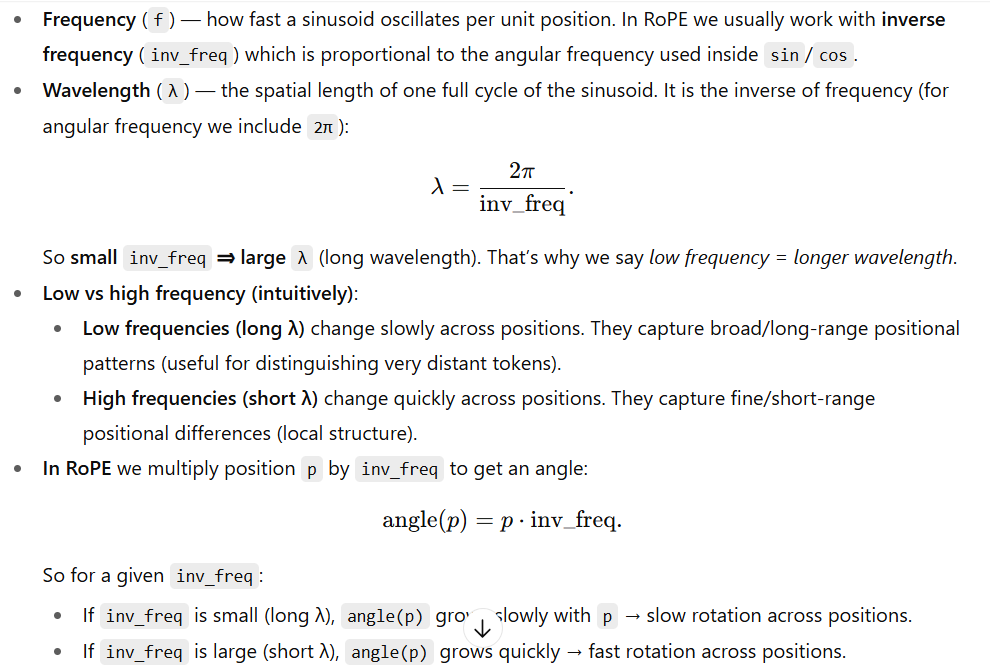

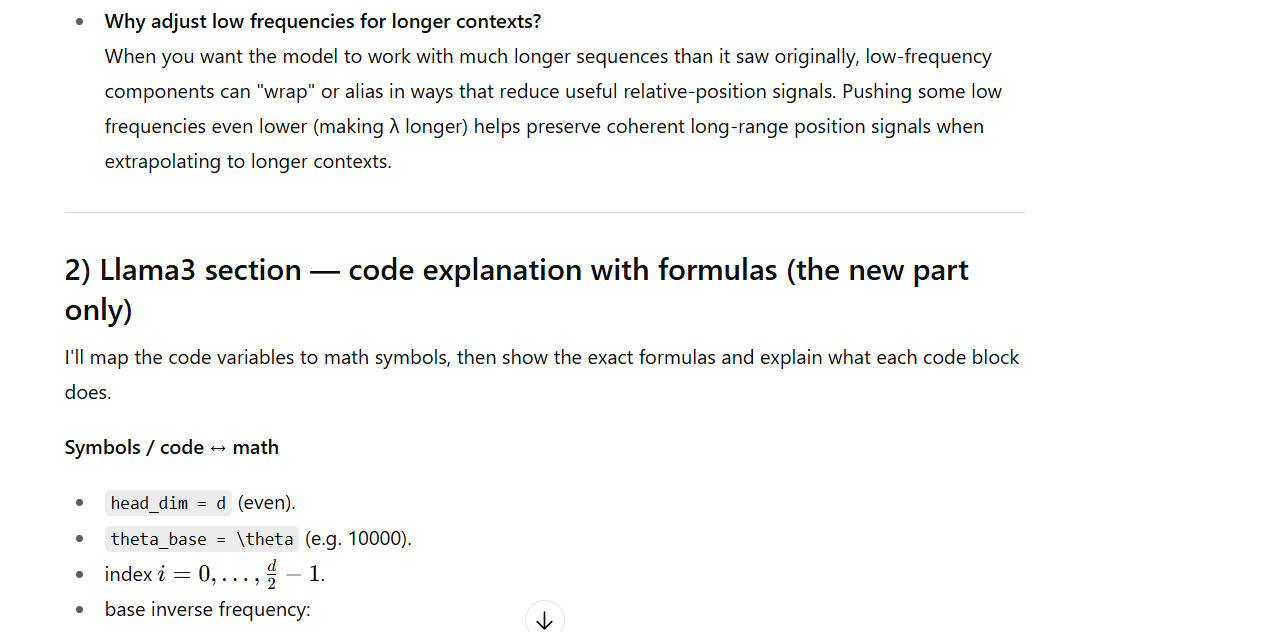

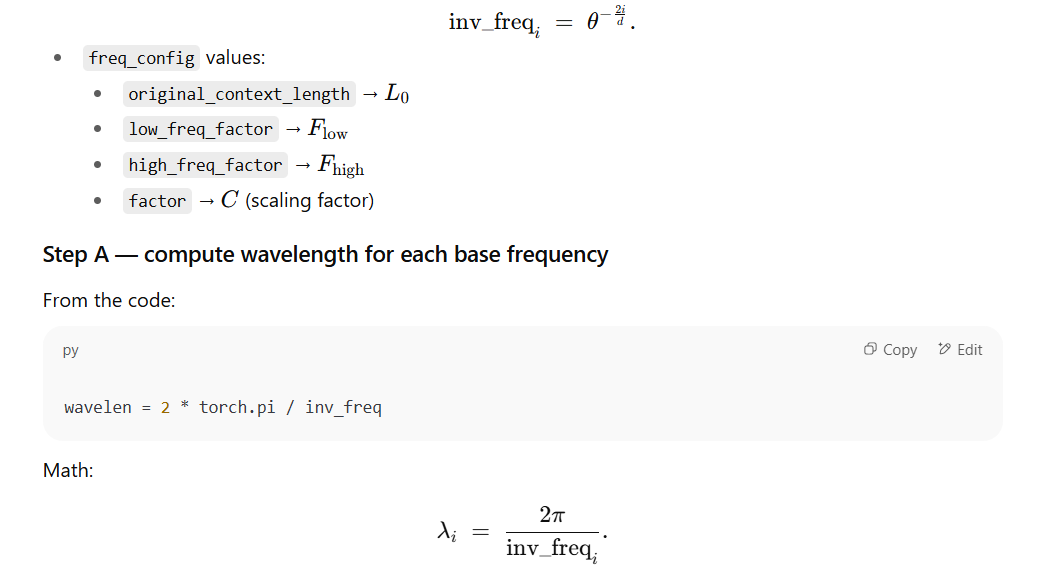

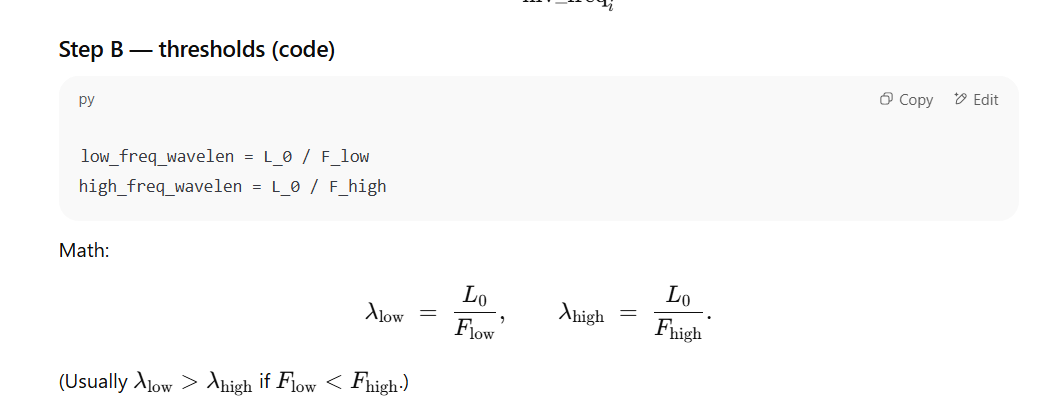

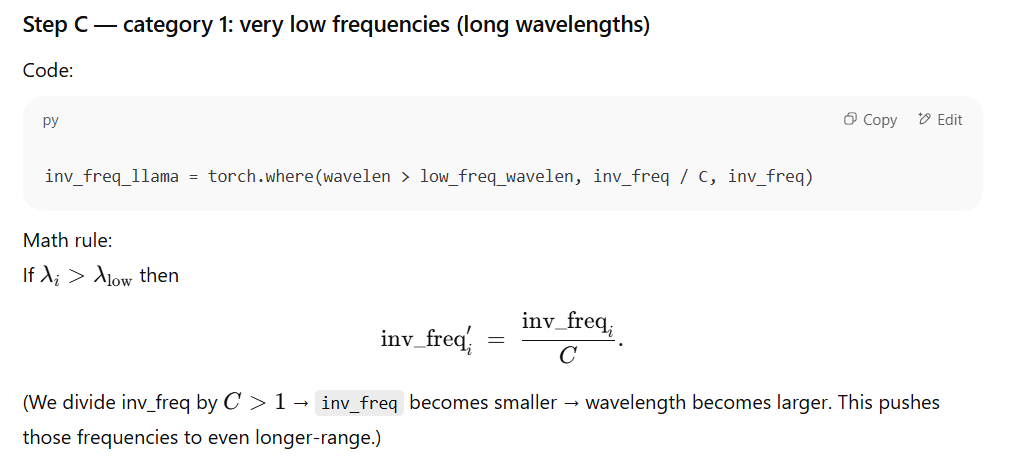

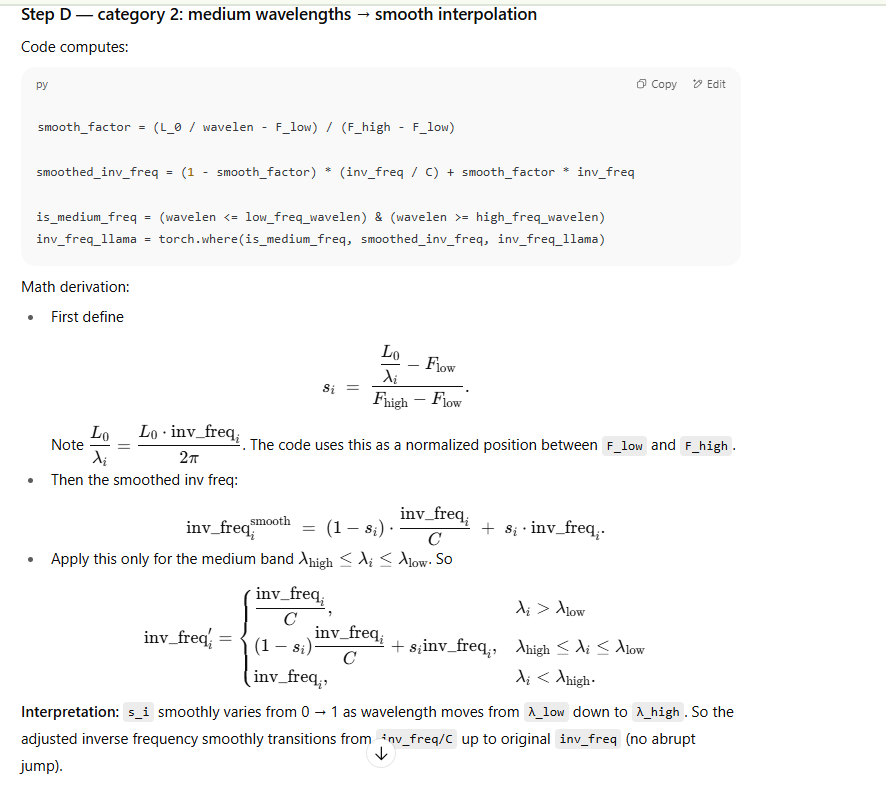

In [1]:
import torch
import torch.nn as nn


class RMSNorm(nn.Module):  # For llama2
  def __init__(self,emb_dim,eps=1e-5):
    super().__init__()
    self.eps = eps
    self.emb_dim = emb_dim
    self.weight = nn.Parameter(torch.ones(self.emb_dim)).float()

  def forward(self,x):
    means = x.pow(2).mean(dim=-1,keepdim=True)
    x_normed = x * torch.rsqrt(self.eps + means)
    return (x_normed * self.weight).to(dtype=x.dtype)

In [2]:
class SiLU(nn.Module):
  def __init__(self):
    super(SiLU,self).__init__()

  def forward(self,x):
    return x * torch.sigmoid(x)

In [3]:
class FeedForward(nn.Module):     #llama2
  def __init__(self,cfg):
    super().__init__()
    self.fc1 = nn.Linear(cfg['emb_dim'],cfg["hidden_dim"],dtype=cfg["dtype"],bias=False)
    self.fc2 = nn.Linear(cfg['emb_dim'],cfg["hidden_dim"],dtype=cfg["dtype"],bias=False)
    self.fc3 = nn.Linear(cfg["hidden_dim"], cfg["emb_dim"], dtype=cfg["dtype"], bias=False) # Corrected dimension
    self.silu = SiLU() # Instantiate the SiLU activation function


  def forward(self,x):
    x_fc1 = self.fc1(x)
    x_fc2 = self.fc2(x)
    x = self.silu(x_fc1) * x_fc2

    return self.fc3(x)

In [4]:
def precompute_rope_params(head_dim, theta_base=10_000, context_length=4096, freq_config=None):
    assert head_dim % 2 == 0, "Embedding dimension must be even"

    # Compute the inverse frequencies
    inv_freq = 1.0 / (theta_base ** (torch.arange(0, head_dim, 2)[: (head_dim // 2)].float() / head_dim))

    ################################ NEW ###############################################
    # Frequency adjustments
    if freq_config is not None:
        low_freq_wavelen = freq_config["original_context_length"] / freq_config["low_freq_factor"]
        high_freq_wavelen = freq_config["original_context_length"] / freq_config["high_freq_factor"]

        wavelen = 2 * torch.pi / inv_freq

        inv_freq_llama = torch.where(
            wavelen > low_freq_wavelen, inv_freq / freq_config["factor"], inv_freq
        )

        smooth_factor = (freq_config["original_context_length"] / wavelen - freq_config["low_freq_factor"]) / (
            freq_config["high_freq_factor"] - freq_config["low_freq_factor"]
        )

        smoothed_inv_freq = (
            (1 - smooth_factor) * (inv_freq / freq_config["factor"]) + smooth_factor * inv_freq
        )

        is_medium_freq = (wavelen <= low_freq_wavelen) & (wavelen >= high_freq_wavelen)
        inv_freq_llama = torch.where(is_medium_freq, smoothed_inv_freq, inv_freq_llama)
        inv_freq = inv_freq_llama
    ####################################################################################


    # Generate position indices
    positions = torch.arange(context_length)

    # Compute the angles
    angles = positions[:, None] * inv_freq[None, :]  # Shape: (context_length, head_dim // 2)

    # Expand angles to match the head_dim
    angles = torch.cat([angles, angles], dim=1)  # Shape: (context_length, head_dim)

    # Precompute sine and cosine
    cos = torch.cos(angles)
    sin = torch.sin(angles)

    return cos, sin

def compute_rope(x, cos, sin):
  batch_size,num_heads,seq_len,head_dim = x.shape

  assert head_dim % 2 == 0

  x1 = x[...,:head_dim//2]
  x2 = x[...,head_dim//2:]

  cos = cos[:seq_len,:].unsqueeze(0).unsqueeze(0)# Shape: (1, 1, seq_len, head_dim)
  sin = sin[:seq_len,:].unsqueeze(0).unsqueeze(0)

  rotated = torch.cat((-x2,x1),dim=-1)
  x_rotated = (x * cos) + (rotated * sin)

  return x_rotated.to(dtype=x.dtype)

In [5]:
# Instantiate RoPE parameters

llama_2_context_len = 4096
llama_3_context_len = 8192

llama_2_theta_base = 10_000
llama_3_theta_base = 500_000

In [6]:
# Settings
batch_size = 2
num_heads = 4
head_dim = 16

# Instantiate RoPE parameters
cos, sin = precompute_rope_params(
    head_dim=head_dim,
    theta_base=llama_3_theta_base,
    context_length=llama_3_context_len
)

# Dummy query and key tensors
torch.manual_seed(123)
queries = torch.randn(batch_size, num_heads, llama_3_context_len, head_dim)
keys = torch.randn(batch_size, num_heads, llama_3_context_len, head_dim)

# Apply rotary position embeddings
queries_rot = compute_rope(queries, cos, sin)
keys_rot = compute_rope(keys, cos, sin)

In [7]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, num_heads, dtype=None):  # ,dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.W_query = nn.Linear(d_in,d_out,bias = False,dtype=dtype)
        self.W_key = nn.Linear(d_in,d_out,bias = False,dtype=dtype)
        self.W_value = nn.Linear(d_in,d_out,bias = False,dtype=dtype)
        self.register_buffer('mask',torch.triu(torch.ones(context_length,context_length),diagonal=1))

        cos,sin = precompute_rope_params(self.head_dim,context_length)
        self.register_buffer('cos',cos)
        self.register_buffer('sin',sin)

    def forward(self,x):
        b,num_tokens,d_in = x.shape
        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)

        keys = keys.transpose(1,2) # Shape: (b, num_heads, num_tokens, head_dim)
        queries = queries.transpose(1,2)
        values = values.transpose(1,2)

        keys = compute_rope(keys,self.cos,self.sin)
        queries = compute_rope(queries,self.cos,self.sin)

        attn_scores = queries @ keys.transpose(2,3) #shape (b, num_heads, num_tokens, num_tokens)
        mask_bool = self.mask.bool()[:num_tokens,:num_tokens]
        attn_scores.masked_fill_(mask_bool,-torch.inf)
        attn_weights = torch.softmax(attn_scores/ keys.shape[-1] ** 0.5,dim=-1)

        context_vec = (attn_weights @ values).transpose(1,2) #shape (b, num_tokens, num_heads, head_dim)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.reshape(b,num_tokens,self.d_out)

        return context_vec

In [8]:
import torch.nn as nn


class GroupedQueryAttention(nn.Module):
    def __init__(
            self, d_in, d_out, num_heads,
            num_kv_groups,       # NEW
            dtype=None
        ):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"
        assert num_heads % num_kv_groups == 0, "num_heads must be divisible by num_kv_groups"  # NEW

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        ############################# NEW  #############################
        # self.W_key = nn.Linear(d_in, d_out, bias=False, dtype=dtype)
        # self.W_value = nn.Linear(d_in, d_out, bias=False, dtype=dtype)
        self.W_key = nn.Linear(d_in, num_kv_groups * self.head_dim, bias=False, dtype=dtype)
        self.W_value = nn.Linear(d_in, num_kv_groups * self.head_dim, bias=False, dtype=dtype)
        self.num_kv_groups = num_kv_groups
        self.group_size = num_heads // num_kv_groups
        ################################################################

        self.W_query = nn.Linear(d_in, d_out, bias=False, dtype=dtype)
        self.out_proj = nn.Linear(d_out, d_out, bias=False, dtype=dtype)


    def forward(self, x, mask=None, cos=None, sin=None):
        ##################### NEW  #####################
        # The forward method now accepts `mask` instead of accessing it via self.mask.
        # Also, we now have cos and sin as input for RoPE
        ################################################
        b, num_tokens, d_in = x.shape

        queries = self.W_query(x)  # Shape: (b, num_tokens, d_out)
        keys = self.W_key(x)  # Shape: (b, num_tokens, num_kv_groups * head_dim)
        values = self.W_value(x)  # Shape: (b, num_tokens, num_kv_groups * head_dim)

        # Reshape queries, keys, and values
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        ##################### NEW  #####################
        # keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        # values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        keys = keys.view(b, num_tokens, self.num_kv_groups, self.head_dim)
        values = values.view(b, num_tokens, self.num_kv_groups, self.head_dim)
        ################################################

        # Transpose keys, values, and queries
        keys = keys.transpose(1, 2)  # Shape: (b, num_kv_groups, num_tokens, head_dim)
        values = values.transpose(1, 2)  # Shape: (b, num_kv_groups, num_tokens, head_dim)
        queries = queries.transpose(1, 2)  # Shape: (b, num_heads, num_tokens, head_dim)

        ##################### NEW #####################
        # Apply RoPE
        if cos is not None:
            keys = compute_rope(keys, cos, sin)
            queries = compute_rope(queries, cos, sin)
        ################################################

        ##################### NEW  #####################
        # Expand keys and values to match the number of heads
        # Shape: (b, num_heads, num_tokens, head_dim)

        keys = keys.repeat_interleave(self.group_size, dim=1)  # Shape: (b, num_heads, num_tokens, head_dim)
        values = values.repeat_interleave(self.group_size, dim=1)  # Shape: (b, num_heads, num_tokens, head_dim)
        # For example, before repeat_interleave along dim=1 (query groups):
        #   [K1, K2]
        # After repeat_interleave (each query group is repeated group_size times):
        #   [K1, K1, K2, K2]
        # If we used regular repeat instead of repeat_interleave, we'd get:
        #   [K1, K2, K1, K2]
        ################################################

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        # Shape: (b, num_heads, num_tokens, num_tokens)
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        ##################### NEW #####################
        # Create mask on the fly
        if mask is None:
            mask = torch.triu(torch.ones(num_tokens, num_tokens, device=x.device, dtype=torch.bool), diagonal=1)
        ################################################

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        assert keys.shape[-1] == self.head_dim

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.reshape(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)  # optional projection

        return context_vec


In [9]:
batch_size = 1
context_len = 3000
max_context_len = 8192
embed_dim = 4096
num_heads = 32


example_batch = torch.randn((batch_size, context_len, embed_dim))

mha = MultiHeadAttention(
    d_in=embed_dim,
    d_out=embed_dim,
    context_length=max_context_len,
    num_heads=num_heads
)

mha(example_batch)

print("W_key:", mha.W_key.weight.shape)
print("W_value:", mha.W_value.weight.shape)
print("W_query:", mha.W_query.weight.shape)

W_key: torch.Size([4096, 4096])
W_value: torch.Size([4096, 4096])
W_query: torch.Size([4096, 4096])


In [10]:
gqa = GroupedQueryAttention(
    d_in=embed_dim,
    d_out=embed_dim,
    num_heads=num_heads,
    num_kv_groups=8,
)

gqa(example_batch)

print("W_key:", gqa.W_key.weight.shape)
print("W_value:", gqa.W_value.weight.shape)
print("W_query:", gqa.W_query.weight.shape)

W_key: torch.Size([1024, 4096])
W_value: torch.Size([1024, 4096])
W_query: torch.Size([4096, 4096])


In [11]:
print("Total number of parameters:")

mha_total_params = sum(p.numel() for p in mha.parameters())
print(f"MHA: {mha_total_params:,}")

gqa_total_params = sum(p.numel() for p in gqa.parameters())
print(f"GQA: {gqa_total_params:,}")

Total number of parameters:
MHA: 50,331,648
GQA: 41,943,040


In [30]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att =  GroupedQueryAttention(  # MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            num_heads=cfg["n_heads"],
            num_kv_groups=cfg["n_kv_groups"],  # NEW
            dtype=cfg["dtype"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = RMSNorm(cfg["emb_dim"], eps=1e-5)
        self.norm2 = RMSNorm(cfg["emb_dim"], eps=1e-5)

    def forward(self, x, mask=None, cos=None, sin=None):
        ##################### NEW  #####################
        # The forward method now accepts `mask` instead of accessing it via self.mask.
        # Also, we now have cos and sin as input for RoPE
        ################################################
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x.to(torch.bfloat16), mask, cos, sin)   # Shape [batch_size, num_tokens, emb_size]
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed-forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x.to(torch.bfloat16))
        x = x + shortcut  # Add the original input back

        return x

In [32]:
class Llama3Model(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"], dtype=cfg["dtype"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = RMSNorm(cfg["emb_dim"], eps=1e-5)
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False, dtype=cfg["dtype"])

        #################### NEW #####################
        cos, sin = precompute_rope_params(
            head_dim=cfg["emb_dim"] // cfg["n_heads"],
            theta_base=cfg["rope_base"],
            context_length=cfg["context_length"],
            freq_config=cfg["rope_freq"]
        )

        self.register_buffer("cos", cos, persistent=False)
        self.register_buffer("sin", sin, persistent=False)
        ##############################################

        self.cfg = cfg

    def forward(self, in_idx):
        tok_embeds = self.tok_emb(in_idx)
        x = tok_embeds

        #################### NEW #####################
        num_tokens = x.shape[1]
        mask = torch.triu(torch.ones(num_tokens, num_tokens, device=x.device, dtype=torch.bool), diagonal=1)
        ##############################################

        for block in self.trf_blocks:
            x = block(x, mask, self.cos, self.sin)
        x = self.final_norm(x)
        logits = self.out_head(x.to(self.cfg["dtype"]))
        return logits

In [33]:
LLAMA3_CONFIG_8B = {
    "vocab_size": 128_256,   # NEW: Larger vocabulary size
    "context_length": 8192,  # NEW: Larger context length
    "emb_dim": 4096,         # Embedding dimension
    "n_heads": 32,           # Number of attention heads
    "n_layers": 32,          # Number of layers
    "hidden_dim": 14_336,    # NEW: Larger size of the intermediate dimension in FeedForward
    "n_kv_groups": 8,        # NEW: Key-Value groups for grouped-query attention
    "rope_base": 500_000.0,  # NEW: The base in RoPE's "theta" was increased to 500_000
    "rope_freq": None,       # NEW: Additional configuration for adjusting the RoPE frequencies
    "dtype": torch.bfloat16  # Lower-precision dtype to reduce memory usage
}

In [34]:
model = Llama3Model(LLAMA3_CONFIG_8B)

In [35]:
def model_memory_size(model, input_dtype=torch.float32):
    total_params = 0
    total_grads = 0
    for param in model.parameters():
        # Calculate total number of elements per parameter
        param_size = param.numel()
        total_params += param_size
        # Check if gradients are stored for this parameter
        if param.requires_grad:
            total_grads += param_size

    # Calculate buffer size (non-parameters that require memory)
    total_buffers = sum(buf.numel() for buf in model.buffers())

    # Size in bytes = (Number of elements) * (Size of each element in bytes)
    # We assume parameters and gradients are stored in the same type as input dtype
    element_size = torch.tensor(0, dtype=input_dtype).element_size()
    total_memory_bytes = (total_params + total_grads + total_buffers) * element_size

    # Convert bytes to gigabytes
    total_memory_gb = total_memory_bytes / (1024**3)

    return total_memory_gb

print(f"float32 (PyTorch default): {model_memory_size(model, input_dtype=torch.float32):.2f} GB")
print(f"bfloat16: {model_memory_size(model, input_dtype=torch.bfloat16):.2f} GB")

float32 (PyTorch default): 59.84 GB
bfloat16: 29.92 GB


In [36]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

model.to(device);

In [ ]:
!pip install tiktoken
!pip install blobfile

In [38]:
from pathlib import Path

import tiktoken
from tiktoken.load import load_tiktoken_bpe


class Tokenizer:
    """Thin wrapper around tiktoken that keeps track of Llama-3 special IDs."""
    def __init__(self, model_path):
        if not os.path.isfile(model_path):
            raise FileNotFoundError(model_path)

        mergeable = load_tiktoken_bpe(model_path)

        # hard-coded from Meta's tokenizer.json
        self.special = {
            "<|begin_of_text|>": 128000,
            "<|end_of_text|>": 128001,
            "<|start_header_id|>": 128006,
            "<|end_header_id|>": 128007,
            "<|eot_id|>": 128009,
        }
        self.special.update({f"<|reserved_{i}|>": 128002 + i
                             for i in range(256)
                             if 128002 + i not in self.special.values()})

        self.model = tiktoken.Encoding(
            name=Path(model_path).name,
            pat_str=r"(?i:'s|'t|'re|'ve|'m|'ll|'d)"
                    r"|[^\r\n\p{L}\p{N}]?\p{L}+"
                    r"|\p{N}{1,3}"
                    r"| ?[^\s\p{L}\p{N}]+[\r\n]*"
                    r"|\s*[\r\n]+"
                    r"|\s+(?!\S)"
                    r"|\s+",
            mergeable_ranks=mergeable,
            special_tokens=self.special,
        )

    def encode(self, text, bos=False, eos=False):
        ids = ([self.special["<|begin_of_text|>"]] if bos else []) \
              + self.model.encode(text)
        if eos:
            ids.append(self.special["<|end_of_text|>"])
        return ids

    def decode(self, ids):
        return self.model.decode(ids)

In [39]:
from huggingface_hub import login
import json

with open("config.json", "r") as config_file:
    config = json.load(config_file)
    access_token = config["HF_ACCESS_TOKEN"]

login(token=access_token)

In [40]:
from huggingface_hub import hf_hub_download

tokenizer_file_path = hf_hub_download(
    repo_id="meta-llama/Meta-Llama-3-8B",
    filename="original/tokenizer.model",
    local_dir="Llama-3-8B"
)

In [41]:
import os
tokenizer = Tokenizer(tokenizer_file_path)

In [42]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text)
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # add batch dimension
    return encoded_tensor


def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)  # remove batch dimension
    return tokenizer.decode(flat.tolist())


def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float('-inf')).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [43]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort", tokenizer).to(device),
    max_new_tokens=30,
    context_size=LLAMA3_CONFIG_8B["context_length"],
    top_k=1,
    temperature=0.
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effortacy Islands millennials grands/upload الثانية от medＤacyLEASE Click infinit surpr Notre domaISIBLEке인은abe occupy.topic mouth kolay ή.extend Mercizando ok
